# Training Deep Covolution GAN Model with FashionMNIST Dataset
In this problem, the goal is to train and visualize the outputs of a simple Deep
Convolutional GAN (DCGAN) to generate realistic-looking (but fake) images of clothing.

Import libraries. Here are the libraries that we are gonna use in this lab.

In [1]:
# Output of plotting commands is displayed directly below the code cell that produced it
%matplotlib inline

# To eliminate warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Keras via TensorFlow
import tensorflow as tf
from tensorflow import keras

# Importing Numpy for handling numpy
import numpy as np

# Importing Matplotlib to plot
import matplotlib.pyplot as plt

# TQDM to see the progress
from tqdm import tqdm

# To display output in Jupyter Notebook
from IPython import display

# import layer
from tensorflow.keras import layers

import glob
import imageio

# To save files
import os
import PIL

# To check running time
import time

# Import dictionary data structure
from collections import defaultdict


### Download FashionMNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


As we can see, there are 46040000 samples in the traning set and 7840000 samples in testing set. 
In the following process, we will only use the training set to train our GAN Model, the generator and the discriminator. 

In [3]:
print(x_train.size)
print(x_test.size)

47040000
7840000


Let try to visulize the data to see what's the images look like. 

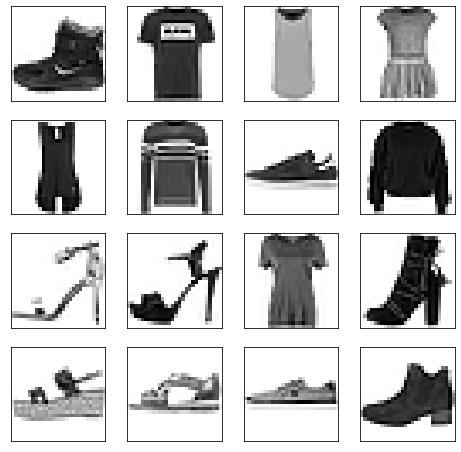

In [4]:
# Fixing plot size for 4x4 matrix of images
plt.figure(figsize=(8,8))
# Plotting 16 random training images as 4x4 matrix
for i in range(16) :
    plt.subplot(4, 4, i+1)
    # cmap - maps numbers to colours based on colormap specified - Here Binary colormap is used
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    # X and Y ticks are set empty
    plt.xticks([])
    plt.yticks([])
# Display the plot in console
plt.show()

### Preprocess the training dataset

Before we train the data, we need to reshape the input images to size 28x28. And we would better do the normalization to the training images. 






In [5]:
# Normalizing training dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

Here we split the images into batches. 

In [6]:
# Set training batches
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Initialize the GAN Model

Create the discriminator of the GAN Model. Here is the architecture of the **discriminator** (kernel size = 5x5 with stride = 2 in both
directions). 


*   2D convolutions (1x28x28 -> 64x14x14 -> 128x7x7)
*  each convolutional layer is equipped with a Leaky ReLU with slope 0.3, followed by Dropout with parameter 0.3.
*  a dense layer that takes the flattened output of the last convolution and maps it to a
scalar.

In [7]:
#Function for Discriminator of GAN
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())  # default slope is 0.3
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())  # default slope is 0.3
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Create the generator of the GAN Model. Here is the architecture of the **generator**. 



*   a dense layer that takes a unit Gaussian noise vector of length 100 and maps it to a
vector of size 7x7x256. No bias terms.
*  several transpose 2D convolutions (256x7x7 -> 128x7x7 -> 64x14x14 -> 1x28x28). No bias terms.
*  each convolutional layer (except the last one) is equipped with Batch Normalization
(BN), followed by Leaky ReLU with slope 0.3. The last (output) layer is equipped with tanh activation (no BN).


In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU()) 

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # default slope is 0.3

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # default slope is 0.3

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

**Check the generator output**

Before we train the generator, we can take a test to see what's the output look like. 

Here we input a Gussian noise first and ask the untrained gernerator to generate an image.

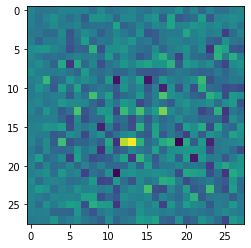

In [11]:
generator = make_generator_model()
noise = tf.random.normal([1, 100]) # A Gaussian noise is a random variable N that has a normal distribution
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

**Check the discriminator output.**

Discriminator can classify the above-generated image as real or fake. The model gives a positive value for the real image and a negative value for the fake image.

The untrained model has classified the above-generated image as fake because it has given a negative value in the output.


In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00620306]], shape=(1, 1), dtype=float32)


### Create Loss function
Use the cross-entropy loss for training both the generator and the discriminator

In [13]:
# Cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Discriminator loss function**

The discriminator loss function quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator’s predictions on real images to an array of 1s, and the discriminator’s predictions on fake (generated) images to an array of 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Generator loss function**

The generator loss function quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, it compares the discriminator’s decisions on the generated images to an array of 1s.



In [15]:
#Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Create the optimizer 
Use the Adam optimizer with learning rate $10^{-4}$ for both the generator and the discriminator.

In [16]:
#Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Initialize the training process

**Set training parameters**

We will train the model with 50 epoches. 
The length of the nosie vector is 100.
We want the generator to generate 16 examples each time.
And the random seeds for each epoch are fixed throughout.


In [18]:
EPOCHS = 50 
noise_dim = 100  # the length of the nosie vector
num_examples_to_generate = 16 # num of images generated by generator each time

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

**Create the training function for each batch** 

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.


In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # A Gaussian noise is a random variable N that has a normal distribution

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

**Generate and save images**

Create a function to visulize and save the generated image of each epoch.


In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  # only plot the image every 10 epoch 
  if epoch % 10 == 0:
    plt.show()
  # clear up the recent image in plot so that when do plot.show() it will only show the latest image
  plt.clf()
  plt.cla()
  plt.close()

**Initilize checkpoint**

Set the path of the checkpoint so that in the training process, the model could be saved before the training is done. 

In [21]:
# set checkpoint
checkpoint_directory = "/content/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=generator_optimizer, model=generator)

**Create the whole Training process function**

For each epoch, we will store all the losses of generator and discriminator in each batch, and calculate the means of these losses as the losses of this epoch. And save the generated images in system. 

For every 15 epoches, we will store the model in system.

For every 10 epoches, we will plot out the generated images of this epoch.

In [22]:
def train(dataset, epochs):
  # store the epoch loss log in history (for ploting the loss log)
  history = defaultdict(list)

  for epoch in range(epochs):
    start = time.time()

    gen_losses = []
    disc_losses = []

    for image_batch in dataset:
      # get and save the loss of each batch
      gen_loss, disc_loss = train_step(image_batch)
      # print(gen_loss.numpy())
      # print(disc_loss.numpy())
      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)

    #To save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print out the use time of this epoch
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # calculate the loss of this epoch using the mean loss of the batch losses
    epoch_gen_loss = np.mean(gen_losses)
    epoch_disc_loss = np.mean(disc_losses)
    print(f'Generator loss {epoch_gen_loss} Discriminator loss {epoch_disc_loss}')

    # store the loss of this epoch in history
    history['gen_loss'].append(epoch_gen_loss)
    history['disc_loss'].append(epoch_disc_loss)

    # To produce images for the GIF
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1,seed)

  return history

**Start the training**

Time for epoch 1 is 11.73589301109314 sec
Generator loss 1.0203509330749512 Discriminator loss 0.822790265083313
Time for epoch 2 is 10.118184566497803 sec
Generator loss 0.9309647679328918 Discriminator loss 1.1615204811096191
Time for epoch 3 is 10.258957147598267 sec
Generator loss 0.7964343428611755 Discriminator loss 1.3250259160995483
Time for epoch 4 is 10.376105546951294 sec
Generator loss 0.8199740648269653 Discriminator loss 1.2983134984970093
Time for epoch 5 is 10.236926794052124 sec
Generator loss 0.6889939308166504 Discriminator loss 1.4524800777435303
Time for epoch 6 is 10.069655179977417 sec
Generator loss 0.7152200937271118 Discriminator loss 1.3849207162857056
Time for epoch 7 is 9.98584794998169 sec
Generator loss 0.7446076273918152 Discriminator loss 1.3526942729949951
Time for epoch 8 is 9.963746309280396 sec
Generator loss 0.7628685235977173 Discriminator loss 1.3231287002563477
Time for epoch 9 is 9.981005430221558 sec
Generator loss 0.8146253824234009 Discrimin

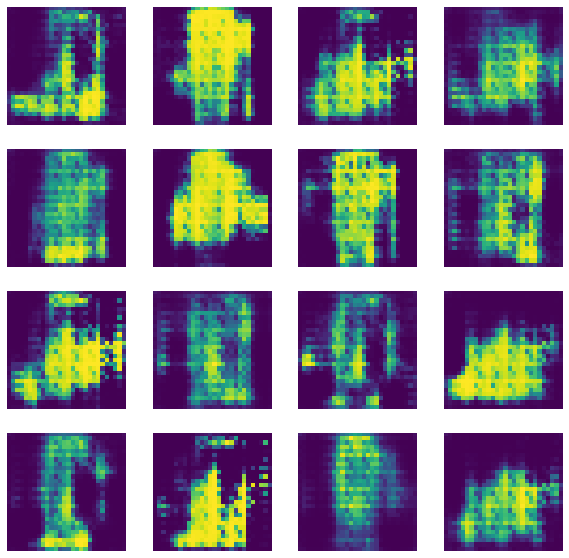

Time for epoch 11 is 10.11931037902832 sec
Generator loss 0.874728798866272 Discriminator loss 1.2223446369171143
Time for epoch 12 is 10.201242685317993 sec
Generator loss 0.9440516829490662 Discriminator loss 1.1592010259628296
Time for epoch 13 is 10.110720157623291 sec
Generator loss 0.9899682998657227 Discriminator loss 1.1407095193862915
Time for epoch 14 is 10.13105583190918 sec
Generator loss 0.9994823932647705 Discriminator loss 1.1380116939544678
Time for epoch 15 is 10.110613346099854 sec
Generator loss 1.122472882270813 Discriminator loss 1.0365321636199951
Time for epoch 16 is 10.102416276931763 sec
Generator loss 1.1344619989395142 Discriminator loss 1.0382862091064453
Time for epoch 17 is 10.039300203323364 sec
Generator loss 1.247948408126831 Discriminator loss 0.9856109619140625
Time for epoch 18 is 10.11872410774231 sec
Generator loss 1.2220646142959595 Discriminator loss 0.9748585820198059
Time for epoch 19 is 10.107070922851562 sec
Generator loss 1.2419264316558838 

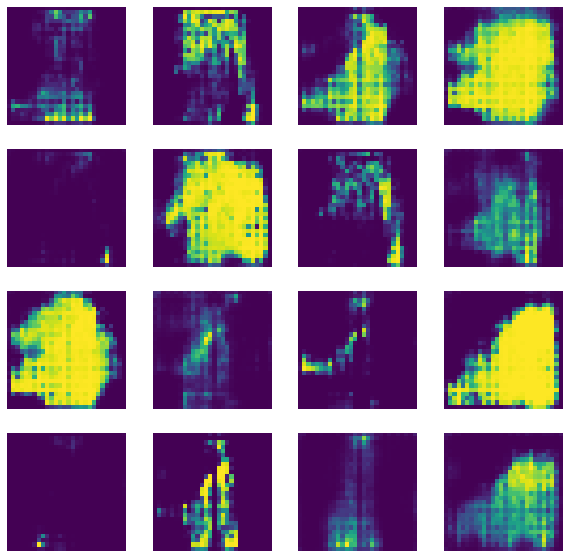

Time for epoch 21 is 10.091469764709473 sec
Generator loss 1.4141414165496826 Discriminator loss 0.8575831651687622
Time for epoch 22 is 10.140584468841553 sec
Generator loss 1.4412341117858887 Discriminator loss 0.8909277319908142
Time for epoch 23 is 10.053950786590576 sec
Generator loss 1.459593415260315 Discriminator loss 0.8417167663574219
Time for epoch 24 is 10.112794876098633 sec
Generator loss 1.3732389211654663 Discriminator loss 0.9428749680519104
Time for epoch 25 is 10.060606718063354 sec
Generator loss 1.4022060632705688 Discriminator loss 0.9040210247039795
Time for epoch 26 is 10.130260467529297 sec
Generator loss 1.4095520973205566 Discriminator loss 0.908897340297699
Time for epoch 27 is 10.079323768615723 sec
Generator loss 1.3260498046875 Discriminator loss 0.95284503698349
Time for epoch 28 is 10.134899139404297 sec
Generator loss 1.4354580640792847 Discriminator loss 0.9072055220603943
Time for epoch 29 is 10.082619190216064 sec
Generator loss 1.5575076341629028 D

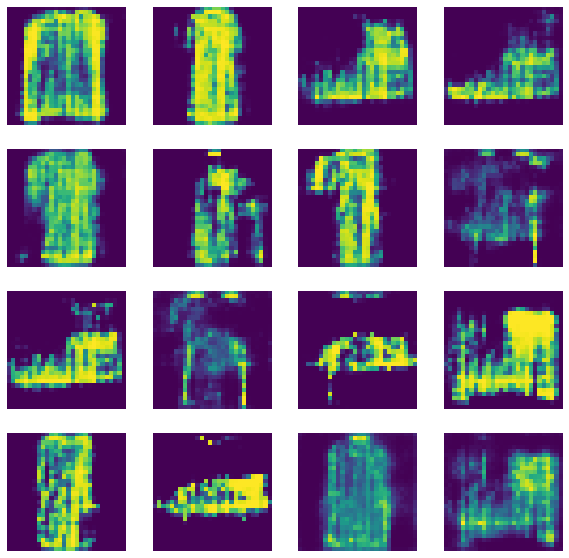

Time for epoch 31 is 10.091476678848267 sec
Generator loss 1.4669601917266846 Discriminator loss 0.9046672582626343
Time for epoch 32 is 10.152603387832642 sec
Generator loss 1.443029761314392 Discriminator loss 0.8872061371803284
Time for epoch 33 is 10.069289684295654 sec
Generator loss 1.4578877687454224 Discriminator loss 0.9054800868034363
Time for epoch 34 is 10.136882543563843 sec
Generator loss 1.4463610649108887 Discriminator loss 0.933057427406311
Time for epoch 35 is 10.098633527755737 sec
Generator loss 1.46802818775177 Discriminator loss 0.9089958071708679
Time for epoch 36 is 10.127974271774292 sec
Generator loss 1.4735177755355835 Discriminator loss 0.895160436630249
Time for epoch 37 is 10.095204830169678 sec
Generator loss 1.461324691772461 Discriminator loss 0.8894368410110474
Time for epoch 38 is 10.137673377990723 sec
Generator loss 1.5204380750656128 Discriminator loss 0.8946443796157837
Time for epoch 39 is 10.079184293746948 sec
Generator loss 1.5998085737228394 

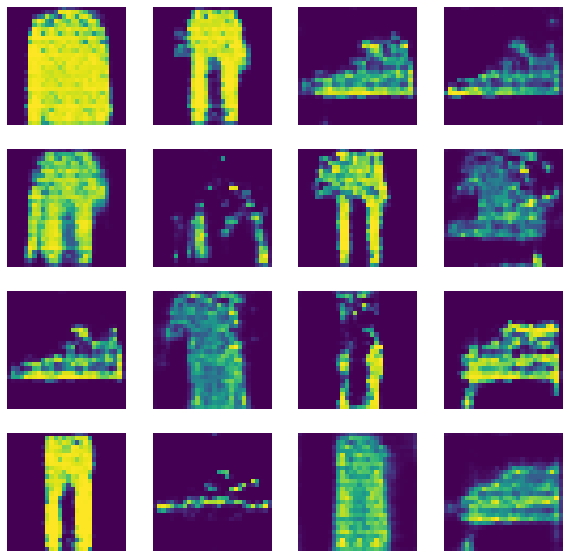

Time for epoch 41 is 10.078598976135254 sec
Generator loss 1.6445047855377197 Discriminator loss 0.8106448650360107
Time for epoch 42 is 10.155843257904053 sec
Generator loss 1.5096031427383423 Discriminator loss 0.9081853628158569
Time for epoch 43 is 10.100455045700073 sec
Generator loss 1.5760600566864014 Discriminator loss 0.8569682836532593
Time for epoch 44 is 10.142987251281738 sec
Generator loss 1.5517184734344482 Discriminator loss 0.8999918103218079
Time for epoch 45 is 10.154078006744385 sec
Generator loss 1.5040225982666016 Discriminator loss 0.9337720274925232
Time for epoch 46 is 10.136878967285156 sec
Generator loss 1.517555832862854 Discriminator loss 0.8952744007110596
Time for epoch 47 is 10.075674772262573 sec
Generator loss 1.396188497543335 Discriminator loss 0.9722222685813904
Time for epoch 48 is 10.143998622894287 sec
Generator loss 1.4726531505584717 Discriminator loss 0.923162579536438
Time for epoch 49 is 10.086167097091675 sec
Generator loss 1.40109682083129

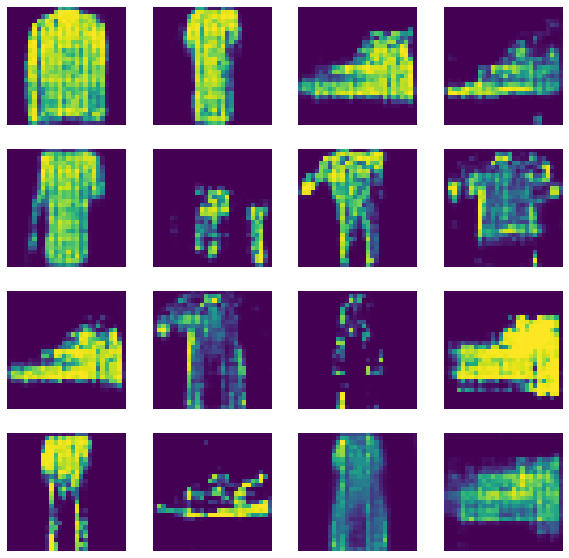

In [23]:
history = train(train_dataset, EPOCHS)

### Visulization the result

Visulization the generated images of Epoch 10, 30, 50.
The first image from the left is the images of Epoch 10. Followed by images of Epoch 30, Epoch 50.

As we can see, the more training epoch generator goes through, the better(more real) images are.

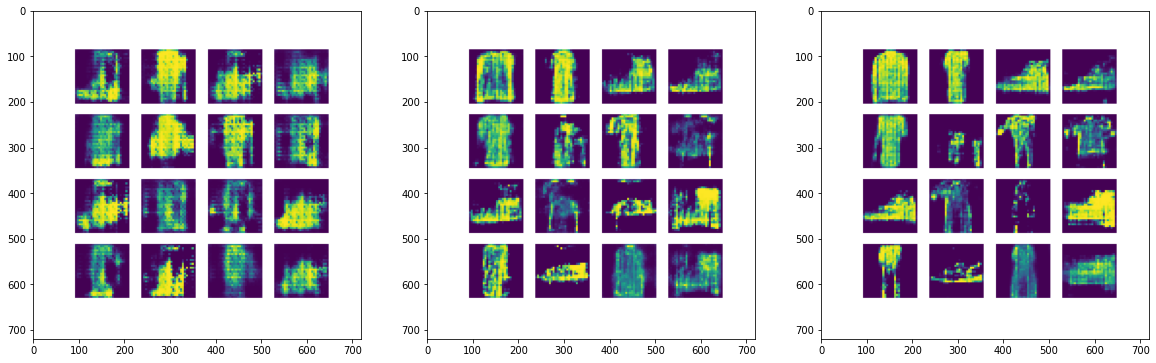

In [24]:
import matplotlib.image as mpimg
# import ipyplot
%matplotlib inline

images = []
images.append(mpimg.imread('/content/image_at_epoch_0010.png'))
images.append(mpimg.imread('/content/image_at_epoch_0030.png'))
images.append(mpimg.imread('/content/image_at_epoch_0050.png'))

plt.figure(figsize=(20,20))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)



check the generator/discriminator loss by plotting the loss curves.

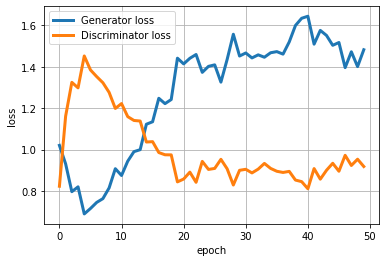

In [25]:
#  Plot generator/discriminator loss.

gen_loss_plot = history['gen_loss'];

disc_loss_plot = history['disc_loss'];

plt.plot(range(EPOCHS),gen_loss_plot,'-',linewidth=3,label='Generator loss')
plt.plot(range(EPOCHS),disc_loss_plot,'-',linewidth=3,label='Discriminator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

As we can see from the loss curve above, the behaviors of generator loss and discriminator loss are opposed. When the generator loss decreases, the discriminator loss increases, and vice versa.  

This pattern is easy to understand. The low loss of the generator means the images it generates are more real. Thus, the discriminator will more likely to regard these fake images as real images, which cause high loss of the discriminator. 